# Individual Profile

In [1]:
# imports
from importlib import reload

import numpy as np
from scipy.interpolate import interp1d

import pandas

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import seaborn as sns

from siosandbox.cugn import clusters
from siosandbox.cugn import grid_utils
from siosandbox.cugn import io as cugn_io
from siosandbox import plot_utils

from gsw import conversions, density
import gsw

# Load up

In [2]:
line = '90'

# Load
items = cugn_io.load_line(line)
grid_tbl = items['grid_tbl']
ds = items['ds']

# Fill
grid_utils.fill_in_grid(grid_tbl, ds)

## Outliers

In [3]:
perc = 98.
grid_outliers, grid_tbl, ds = grid_utils.gen_outliers(line, perc)
#
clusters.generate_clusters(grid_outliers)
cluster_stats = clusters.cluster_stats(grid_outliers)
#
grid_outliers.head()

Found 386 unique clusters


,depth,profile,row,col,doxy,doxy_p,time,lon,z,CT,SA,sigma0,SO,N,chla,T,cluster
428,0,32603,8,17,271.433326,99.404762,2017-02-01 03:39:32,-117.753245,10,14.654321,33.139081,24.504415,1.072125,5.121043,0.831730,14.617091,-1
457,0,32632,8,17,270.994527,98.809524,2017-02-03 16:14:25,-118.194357,10,14.699172,33.134276,24.491252,1.071305,5.872325,0.520608,14.661700,-1
739,0,32915,17,23,262.626988,98.569726,2017-03-09 01:01:53,-119.233425,10,13.575289,33.498791,25.002377,1.017881,2.216568,0.740545,13.549200,-1
740,0,32916,16,22,264.967930,99.410898,2017-03-09 03:58:30,-119.203970,10,13.836013,33.487203,24.940452,1.032276,4.751856,0.815661,13.809083,-1
782,0,32958,15,18,277.438868,99.488491,2017-03-14 02:17:03,-118.227115,10,15.488374,33.434623,24.549290,1.116404,7.360446,0.285907,15.456250,0


# Grab one

In [4]:
ijul2017 = np.argmin(np.abs(grid_outliers.time - pandas.Timestamp('2017-07-15')))
iout = grid_outliers.iloc[ijul2017]
iout

depth                        0
profile                  33961
row                         19
col                         14
doxy                 386.81845
doxy_p               99.610895
time       2017-07-11 17:33:17
lon                 -117.46461
z                           10
CT                   17.558756
SA                   33.615778
sigma0               24.210958
SO                    1.621734
N                    17.645934
chla                  2.813857
T                    17.526182
cluster                      4
Name: 1762, dtype: object

# Generate the profiles

In [5]:
iprofile = ds.profile.values == iout.profile
#

## Plot

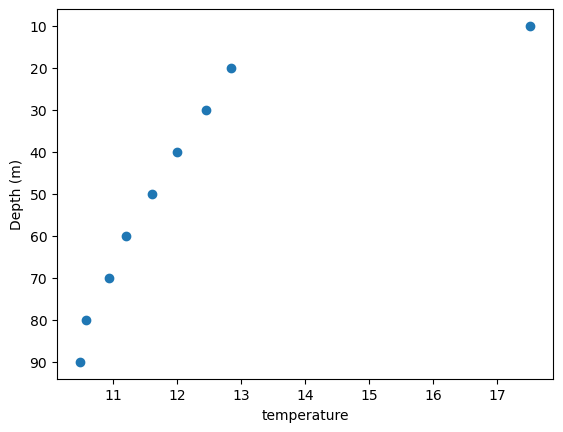

In [6]:
plt.clf()
ax = plt.gca()
#
#metric = 'sigma0'
metric = 'temperature'
ax.plot(ds[metric].data[:,iprofile], ds.depth, 'o')
#
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel(metric)
plt.show()

## Sample

In [7]:
high_SO = cluster_stats.max_SO > 1.1
np.sum(high_SO)

37

### Plot 10

In [8]:
ran10 = np.random.choice(cluster_stats[high_SO].cluster, size=10)

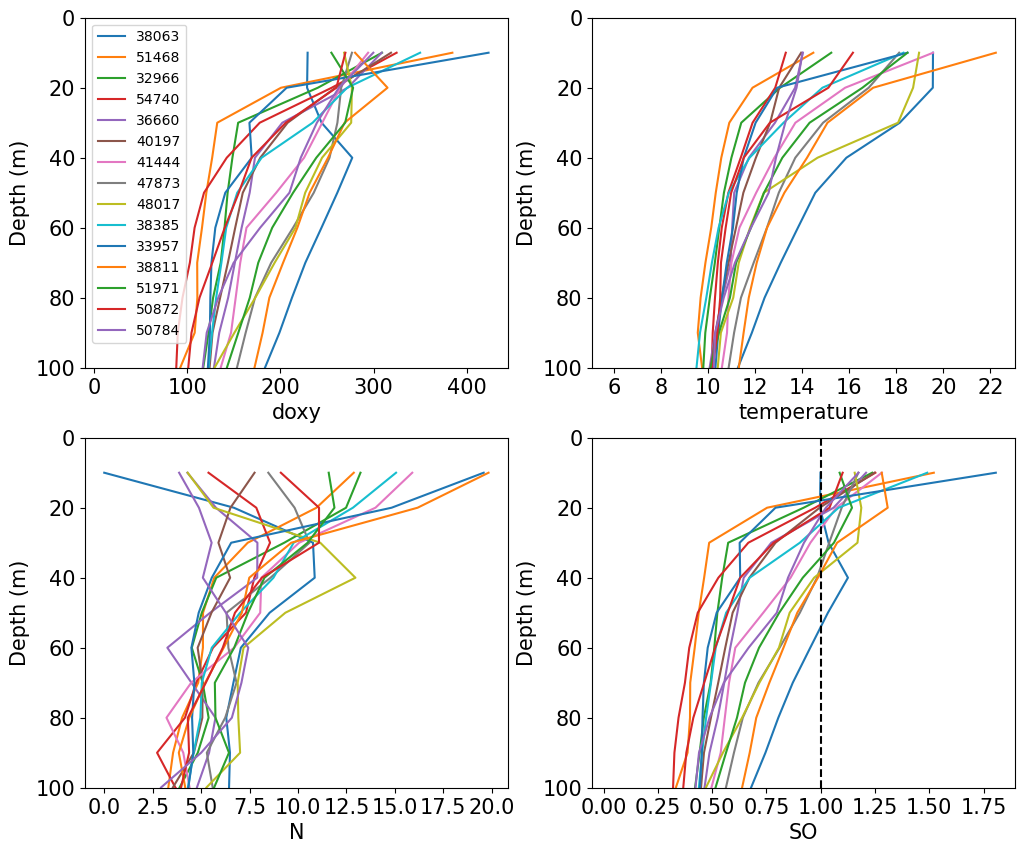

In [11]:
ranN = np.random.choice(cluster_stats[high_SO].cluster, size=15, replace=False)
# 
fig = plt.figure(figsize=(12,10))
plt.clf()
#ax = plt.gca()
gs = gridspec.GridSpec(2,2)
#
#metric = 'sigma0'
#metric = 'temperature'

metrics = ['doxy', 'temperature', 'N', 'SO']
#metrics = ['doxy', 'temperature', 'N', 'DT']
for ss, metric in enumerate(metrics):
    ax = plt.subplot(gs[ss])
    for iran in ranN:
        in_out = grid_outliers.cluster == iran
        grid_in = grid_outliers[in_out]
        imax = np.argmax(grid_in.SO)
        iprofile = grid_in.iloc[imax].profile

        # Plot
        if ss == 0:
            lbl=f'{iprofile}'
        else:
            lbl = None
        if metric == 'DT':
            T = ds['temperature'].data[:,iprofile]
            DT = T - np.roll(T,-1) 
            ax.plot(DT, ds.depth, 'o', label=lbl)
        else:
            ax.plot(ds[metric].data[:,iprofile], ds.depth, label=lbl)

    ax.invert_yaxis()
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(metric)
    if ss == 0:
        ax.legend()
    if metric == 'SO':
        ax.axvline(1., color='k', ls='--')
    #
    ax.set_ylim(100., 0)
    #
    plot_utils.set_fontsize(ax, 15.)

plt.savefig('fig_4profiles.png', dpi=300)

plt.show()

# doxy, SO vs. T

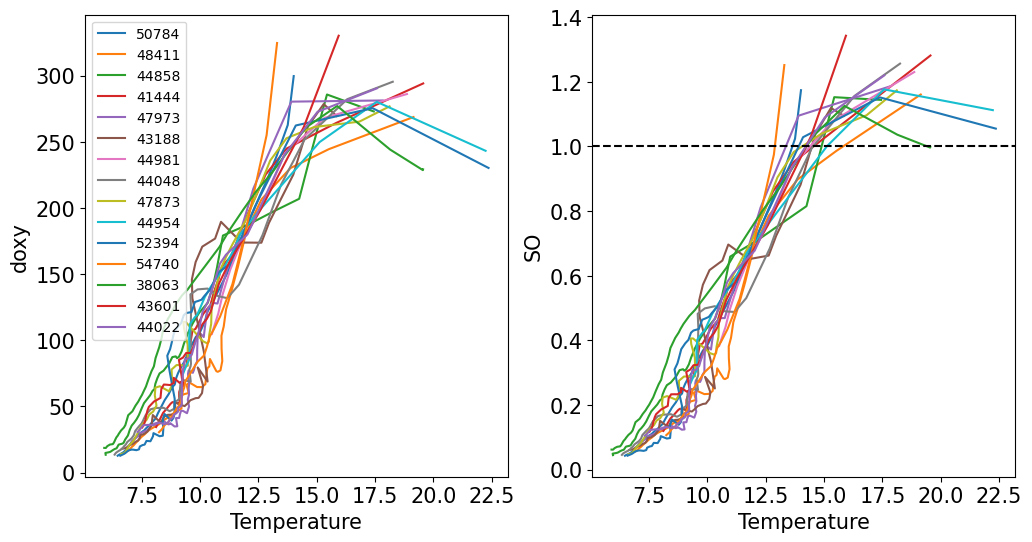

In [16]:
ranN = np.random.choice(cluster_stats[high_SO].cluster, size=15, replace=False)
# 
fig = plt.figure(figsize=(12,6))
plt.clf()
#ax = plt.gca()
gs = gridspec.GridSpec(1,2)
#
#metric = 'sigma0'
#metric = 'temperature'

metrics = ['doxy', 'SO']
#metrics = ['doxy', 'temperature', 'N', 'DT']
for ss, metric in enumerate(metrics):
    ax = plt.subplot(gs[ss])
    for iran in ranN:
        in_out = grid_outliers.cluster == iran
        grid_in = grid_outliers[in_out]
        imax = np.argmax(grid_in.SO)
        iprofile = grid_in.iloc[imax].profile

        # Plot
        if ss == 0:
            lbl=f'{iprofile}'
        else:
            lbl = None
        ax.plot(ds['temperature'].data[:,iprofile], ds[metric].data[:,iprofile], label=lbl)

    #ax.invert_yaxis()
    ax.set_xlabel('Temperature')
    ax.set_ylabel(metric)
    if ss == 0:
        ax.legend(loc='upper left')
    if metric == 'SO':
        ax.axhline(1., color='k', ls='--')
    #
    #ax.set_ylim(100., 0)
    #
    plot_utils.set_fontsize(ax, 15.)

plt.savefig('fig_Tprofiles.png', dpi=300)

plt.show()